In [381]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [7]:
# The directory which stores all the .dat files
directory = 'C:\\Program Files (x86)\\USGS\\Phreeqc Interactive 3.7.3-15968\\database\\'

def logkdata(filename):
    # filename needs to be input as a string
    # Parameters that need to be changed for each computer?
    p2 = filename
    path = directory+p2

    # Read every line within the file, reads line as a string into a list called output
    with open(path,'r',encoding='utf-8') as f:
        output = f.readlines()

    num_lines = len(output)

    # The chemical needed is usually not indented, with all the relevant information being indented underneath
    # Because of this, we will try to order the information by checking for indentation

    species = []
    log_k = []

    # Pad the end of the text file with two new lines to prevent loop out of range when searching for logk
    output.append('\n')
    output.append('\n')

    # Create a list of all the excess values that will be read that need to be removed
    noise_list = [" ", "\n", "#", "log_k", "primarymasterspecies", ";", "\t", "=pKa1,int", "=pKa2,int", "=-pKa2,int"]

    # Create a function that removes the excess from the string that is read
    def cleaner(string, noise = noise_list):
        for i in noise:
            string = string.replace(i, "")
        return string

    # Loop over the information for each line
    for i in range(num_lines):
        # If there is an equals sign there is a chance it is one of the species we need to add with its log k value
        # Check if the line has an equals sign
        if output[i].find('=') != -1:
            # Search for the lines with log_k data
            # Find function returns the starting index of the substring
            # If the substring does not exist within the line, it returns -1
            # First check if the same line has the log_k value
            if output[i].find('log_k') != -1:
                # Seperate the string by where log k is written
                # Before is everything before the input partition, partition is 'log_k' and after is everything after
                before, partition, after = output[i].partition('log_k')
                # Use the cleaner function to get just the specie and log k value before adding to the list
                after = cleaner(after)
                before = cleaner(before)
                log_k.append(after)
                species.append(before)
            # Carry out another similar check for the log k value on the next line
            elif output[i+1].find('log_k') != -1:
                # Partition and clean the next line
                before, partition, after = output[i+1].partition('log_k')
                after = cleaner(after)
                b = cleaner(output[i])
                log_k.append(after)
                species.append(b)
            # Carry out one last check 2 lines after the species to find log_k value
            elif output[i+2].find('log_k') != -1:
                # Partition and clean the line again
                before, partition, after = output[i+2].partition('log_k')
                after = cleaner(after)
                b = cleaner(output[i])
                log_k.append(after)
                species.append(b)
            else:
                continue
    # Species are now in one list and log_k are in the other
    # Join them together into one pandas dataframe

    df = pd.DataFrame(list(zip(species, log_k)), columns =['Species', 'Log_k_values'])
    # Convert all the log k values to float. Convert to NaN if they can't be converted
    df.Log_k_values = df.Log_k_values.apply(pd.to_numeric, errors='coerce')
    # Drop all rows with NaN
    df = df.dropna() 
    return df

In [8]:
logkdata('Tipping_Hurley.dat')

,Species,Log_k_values
0,H+=H+,0.00
1,e-=e-,0.00
2,H2O=H2O,0.00
3,Ag+=Ag+,0.00
4,Al+3=Al+3,0.00
...,...,...
928,H_cdH2+Pb+2=H_cdPb+2H+,-1.62
929,H_cfH2+Pb+2=H_cfPb+2H+,-3.85
930,H_chH2+Pb+2=H_chPb+2H+,-3.85
931,H_deH2+Pb+2=H_dePb+2H+,-3.85


In [9]:
logkdata('minteq.dat')

,Species,Log_k_values
0,e-=e-,0.00
1,H+=H+,0.00
2,H2O=H2O,0.00
3,2H2O=O2+4H++4e-,-86.08
4,2H++2e-=H2,-3.15
...,...,...
1604,Hfo_wOH+H3AsO4=Hfo_wAsO4-2+H2O+2H+,-4.70
1605,Hfo_sOH+H3AsO4=Hfo_sOHAsO4-3+3H+,-10.15
1606,Hfo_wOH+H3AsO4=Hfo_wOHAsO4-3+3H+,-10.15
1607,Hfo_sOH+H3BO3=Hfo_sH2BO3+H2O,0.62


In [10]:
# Create a function to check whether a value is in a specific dataset

# Empty list to store all file names
filenames = []

# iterate over files in the database directory
for filename in os.listdir(directory):
    var = os.path.join(directory, filename)
    # Add the variable filename to the list
    if os.path.isfile(var):
        filenames.append(filename)

def checker(species):
    # Species must be entered as a string
    # Check all values in the species column for if they match the input
    # If there is a partial string match to the input, it returns true
    # Does take into account numbers and capitalisation (e.g. 2H2O)
    # Doesn't take into account signs (e.g. H+ and H give same result)

    # iterate over filenames
    for i in filenames:
        # Load the database into this variable
        DataBase = logkdata(i)
        # Create a smaller databse consisting of lines only containing the input species
        # Database[condition]
        DB_check = DataBase[DataBase.Species.str.contains(species) == True]
        # Print the name and the database in between new lines for easy reading
        print('\n', i, '\n', DB_check)

In [76]:
checker('Mn3O4')


 Amm.dat 
                       Species  Log_k_values
244  Mn3O4+8H++2e-=3Mn+2+4H2O         61.03

 ColdChem.dat 
 Empty DataFrame
Columns: [Species, Log_k_values]
Index: []

 core10.dat 
                        Species  Log_k_values
381  Mn3O4+8H+=Mn+2+2Mn+3+4H2O       10.1598

 frezchem.dat 
 Empty DataFrame
Columns: [Species, Log_k_values]
Index: []

 iso.dat 
 Empty DataFrame
Columns: [Species, Log_k_values]
Index: []

 llnl.dat 
                                                Species  Log_k_values
1743  Mn3O4+8.0000H+=+1.0000Mn+++2.0000Mn++++4.0000H2O       10.1598

 minteq.dat 
                        Species  Log_k_values
1139  Mn3O4+8H++2e-=3Mn+2+4H2O         61.54

 minteq.v4.dat 
                        Species  Log_k_values
1536  Mn3O4+8H++2e-=3Mn+2+4H2O         61.03

 phreeqc.dat 
                       Species  Log_k_values
246  Mn3O4+8H++2e-=3Mn+2+4H2O         61.03

 pitzer.dat 
 Empty DataFrame
Columns: [Species, Log_k_values]
Index: []

 sit.dat 
 Empty DataFrame
Co

In [433]:
# Given the previous search, the user would want to select a log k value themselves from the database
# Allow the user to input the relevant values and output the required graph
# After choosing a reaction: number of moles and charge of the ion need to be taken to calculate the stability constant

example = '2Zn+2 + 2Cit-3 + 2H2O = Zn2(OH)2Cit2-4 + 2H+'

# ionic strength values to calculate stability constant for
ionic_str = [0.05, 0.15, 0.3, 0.5, 1]

# Function to check whether a value can be an integer or not
# Input must be a string
def int_check(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

def stability_graph(str_var):
    # First get rid of all spaces within the equation if any
    str_var = str_var.replace(" ", "")
    
    # Split the equation into before and after the equal sign
    # Calculations for each side will be done separately
    before, partition, after = str_var.partition('=')
    # Split for each of the reactants in the equations by the + sign
    splitone = re.split(r"[+]", before)
    splittwo = re.split(r"[+]", after)
    
    # This splitting will also split on a + charge at the end of a reactant
    # it will instead add '' or the number as an extra variable to the list
    # Add back the correct charge if this is the case and remove empty variable from the list
    for i in range(len(splitone)):
        if splitone[i] == '':
            splitone[i-1]+='+'
        if int_check(splitone[i]) == True:
            splitone[i-1]+='+' + splitone[i]
            # Replace the int with '' so that it is removed from the list later
            splitone[i] = ''
    
    for i in range(len(splittwo)):
        if splittwo[i] == '':
            splittwo[i-1]+='+'
        if int_check(splittwo[i]) == True:
            splittwo[i-1]+='+' + splittwo[i]
            # Replace the int with '' so that it is removed from the list later
            splittwo[i] = ''
    
    # Remove the empty '' variables from within the list if they exist
    while '' in splitone:
        splitone.remove('')
    
    while '' in splittwo:
        splittwo.remove('')
    
    # Empty list to store the stability constant at each salinity level for the reaction
    stab_const = []
    
    # Each calculation is done for each salinity level
    for j in range(len(ionic_str)):
        # Following equation spreadsheet from George's paper calculations
        # Variable names follow the column in his spreadsheet
        E = (ionic_str[j]**0.5)/(1+(ionic_str[j]**0.5))
        F = -0.3 * ionic_str[j]
        
        # Empty lists to store the stability constants for the LHS and RHS of the reaction
        LHS = []
        RHS = []
        
        # For each variable in the lists, calculate the activity coefficient at the given salinity level
        # First get all variables that are needed for each compound in the equations
        for i in range(len(splitone)):
            # Find the number of moles of the compound
            # If it begins with a number, find the whole number, otherwise it is 1 mole
            if splitone[i][0].isdigit() == True:
                moles = re.search(r'(\d+)',splitone[i]).group()
                moles = int(moles)
            else:
                moles = 1 
            # Find the charge as a symbol followed by an optional number
            charge = re.findall('[+|-][0-9]?', splitone[i])
            # Convert the charge into an integer value
            if charge == []:
                charge = 0
            elif charge == ['+']:
                charge = 1
            elif charge == ['-']:
                charge = -1
            else:
                charge = int(charge[0])
                
            # Following the equation from George's paper to find the stability constant
            # -0.51 is the dialectric constant for the solvent, should this change? be user input??
            D = -0.51*charge**2
            G = D*(E+F)*moles
            LHS.append(G)
            
        for i in range(len(splittwo)):
            # Find the number of moles of the compound
            # If it begins with a number, find the whole number, otherwise it is 1 mole
            if splittwo[i][0].isdigit() == True:
                moles = re.search(r'(\d+)',splittwo[i]).group()
                moles = int(moles)
            else:
                moles = 1 
            # Find the charge as a symbol followed by an optional number
            charge = re.findall('[+|-][0-9]?', splittwo[i])
            # Convert the charge into an integer value
            if charge == []:
                charge = 0
            elif charge == ['+']:
                charge = 1
            elif charge == ['-']:
                charge = -1
            else:
                charge = int(charge[0])
                
            # Following the equation from George's paper to find the stability constant
            # -0.51 is the dialectric constant for the solvent, should this change? be user input??
            D = -0.51*charge**2
            G = D*(E+F)*moles
            RHS.append(G)
        
        # Sum the completed RHS and LHS sides and subtract appropriately
        sc = sum(RHS) - sum(LHS)
        stab_const.append(sc)
    
    # Create polynomial of order 2
    poly = np.polyfit(ionic_str, stab_const, 2)
    # Create a range of values between which a line of best fit will be made
    x = np.linspace(ionic_str[0], ionic_str[-1], num = 100)
    polynomial = np.polyval(poly, x)
    
    # Using the values, plot the graph against salinity with polynomial line of best fit
    plt.scatter(ionic_str, stab_const)
    plt.title('%s' %(str_var))
    plt.xlabel('Ionic Strength (mol/dm$^{3}$)')
    plt.ylabel('Stability Constant (log β)')
    plt.plot(x, polynomial, '-')  
    plt.show()

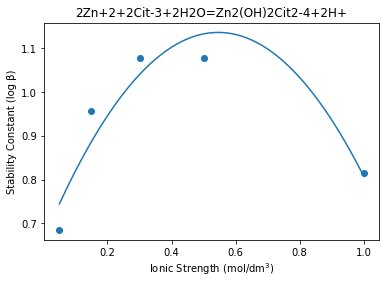

In [434]:
# example = '12Zn+2 + 2Cit-3 + 2H2O = Zn2(OH)2Cit2-4 + 2H+'
stability_graph(example)